In [1]:
%load_ext autoreload
%autoreload 2

import soft_renderer as sr
from torch_openpose.body import Body
from torch_openpose import util
from matplotlib import pyplot as plt
from matplotlib import cm
import copy
import numpy as np
import cv2
from PIL import Image
import torch

In [2]:
# other settings
camera_distance = 2.0
elevation = 20
azimuth = 180
ORIG_SHAPE = (256, 256, 3)

body_estimation = Body('/home/ax/data/programs/pytorch-openpose/model/body_pose_model.pth', True)

# set defaults
body_estimation.imageToTest_padded_shape = ORIG_SHAPE
body_estimation.pad = [0, 0, 0, 0]

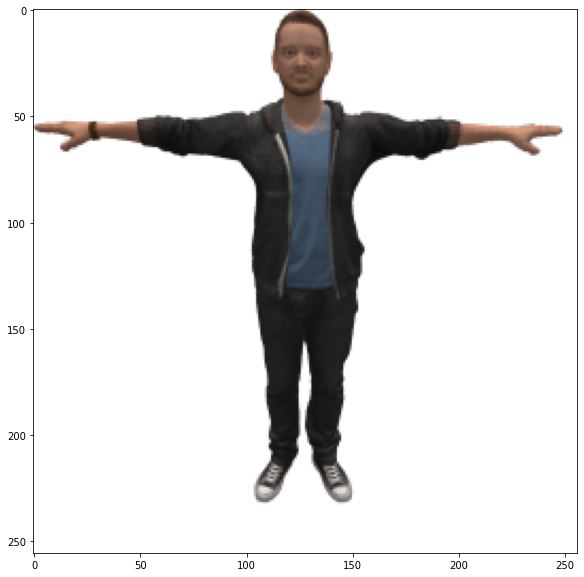

In [3]:
texture_type = 'surface'

# load from Wavefront .obj file
mesh = sr.Mesh.from_obj('sr_test/pose_0_1_meshlab.obj',
                        load_texture=True, texture_res=5, texture_type=texture_type, normalization=True)


# create renderer with SoftRas
renderer = sr.SoftRenderer(camera_mode='look_at',
                           light_mode=texture_type,
                           texture_type=texture_type
                           )

mesh.reset_()

renderer.transform.set_eyes_from_angles(camera_distance, elevation, azimuth)
#images = renderer.render_mesh(mesh) #  vertices, faces, textures=None, mode=None, texture_type='surface'

verticies = mesh.vertices
verticies.requires_grad = True
faces = mesh.faces
textures = mesh.textures
images = renderer(
    verticies,
    faces,
    textures,
    texture_type,
    texture_type
)
image = images.detach().cpu().numpy()[0].transpose((1, 2, 0))

fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image)


In [5]:
ATTRIBUTION_INDEX = 4
body_input = images[:, :3, :, :] - 0.5 

paf, heat = body_estimation.model(body_input )
# TODO: add better mask
loss = heat[0, ATTRIBUTION_INDEX, :, :].mean()
print(loss.item())
loss.backward(retain_graph=True)

0.004415951203554869


In [6]:
body_input.shape

torch.Size([1, 3, 256, 256])

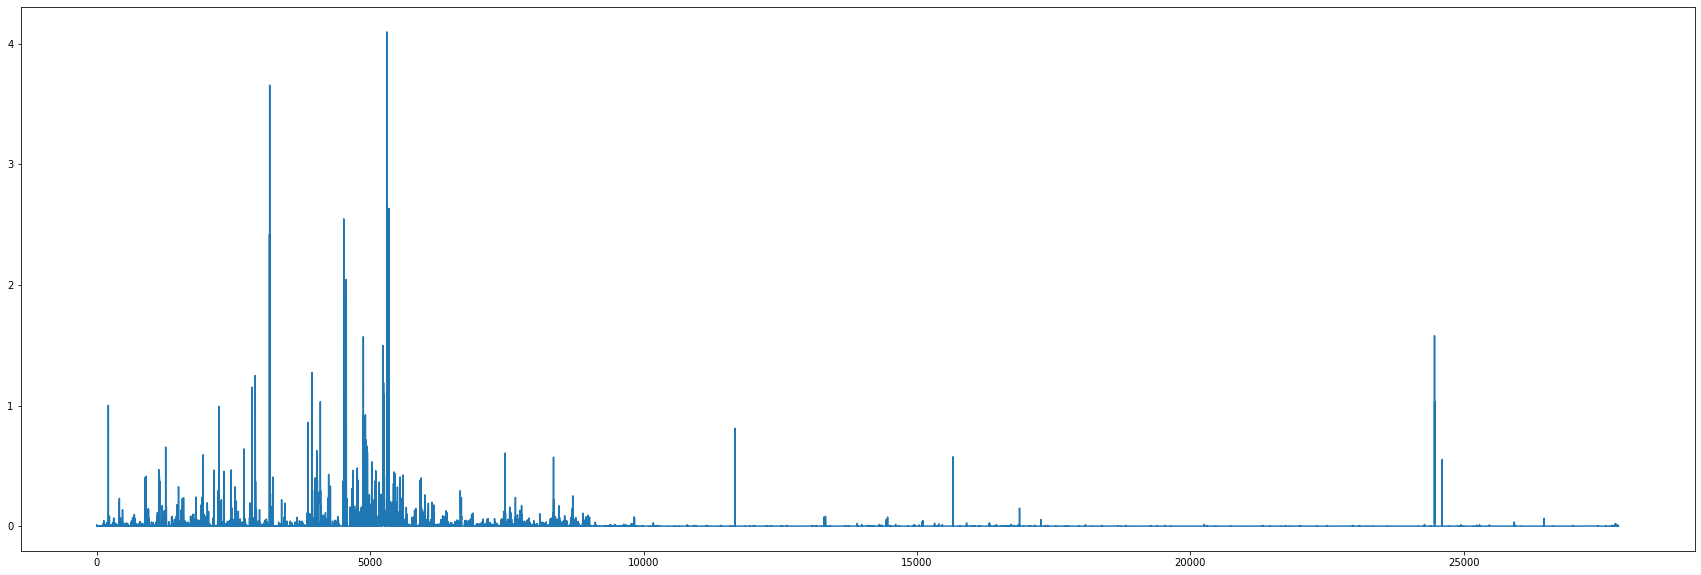

In [142]:
grad_np = verticies.grad.detach().cpu().numpy()[0]
grad_norm = np.linalg.norm(grad_np, axis=1)

fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(grad_norm)

grad_norm /= 0.001 # scale up to have a nice vis

color_map = cm.get_cmap('hot')

rgb_vertex_colormap = np.array([color_map(grad_norm)[:, :3]], dtype=np.float32)

In [131]:
heat_vertex_texture = torch.from_numpy(rgb_vertex_colormap).cuda()
heat_mesh = sr.Mesh(verticies, faces, heat_vertex_texture, texture_res=1, texture_type='vertex')

print(heat_vertex_texture.shape)

torch.Size([1, 27829, 3])


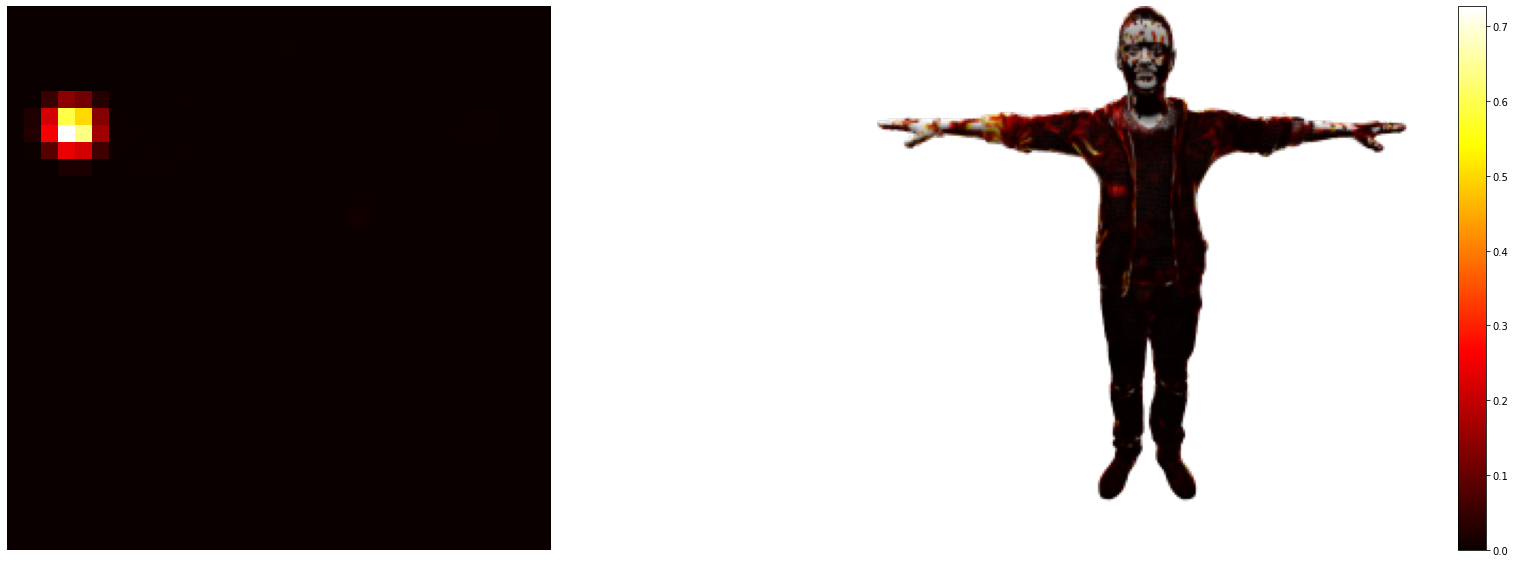

In [141]:
heat_renderer = sr.SoftRenderer(camera_mode='look_at', light_mode='vertex', texture_type='vertex')

heat_mesh.reset_()
heat_renderer.transform.set_eyes_from_angles(camera_distance, elevation, 180)
heat_images = heat_renderer.render_mesh(heat_mesh)
heat_image = heat_images.detach().cpu().numpy()[0].transpose((1, 2, 0))

heatmap = heat[0, ATTRIBUTION_INDEX, :, :].detach().cpu().numpy()

fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 2, 1)
pcm = ax.imshow(heatmap,  cmap='hot')
ax.axis('off')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(heat_image)
ax.axis('off')
fig.colorbar(pcm, ax=ax, cmap='hot')

In [43]:
print(images.shape)
heatmap_avg, paf_avg = body_estimation.compute_heatmap_paf_avg(images[:, :3, :, :], ORIG_SHAPE)
candidate, subset = body_estimation.get_pose(heatmap_avg, paf_avg, ORIG_SHAPE)

Text(0.5, 1.0, 'front')

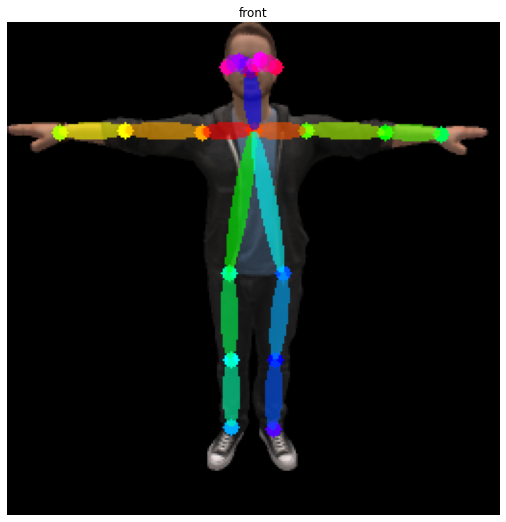

In [44]:
rendering_torch_np = images.detach().cpu().numpy()[0].transpose((1, 2, 0)).astype(np.float32)[:,:,:3]
pil_image = Image.fromarray(np.uint8(rendering_torch_np*255))
canvas = np.array(pil_image)

canvas = util.draw_bodypose(canvas, candidate, subset)

fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(canvas)
ax.axis('off')
ax.set_title('front')